In [2]:
import os
from pcxarray import pc_query, prepare_timeseries
from pcxarray.utils import load_census_shapefile
from distributed import Client # dask distributed client
import matplotlib.pyplot as plt
from IPython.display import HTML
from matplotlib.animation import FuncAnimation

In [3]:
client = Client(n_workers=os.cpu_count(), memory_limit="2GB")
display(client)

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 24
Total threads: 24,Total memory: 44.70 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:44201,Workers: 0
Dashboard: http://127.0.0.1:8787/status,Total threads: 0
Started: Just now,Total memory: 0 B
Comm: tcp://127.0.0.1:34975,Total threads: 1
Dashboard: http://127.0.0.1:37711/status,Memory: 1.86 GiB
Nanny: tcp://127.0.0.1:42699,


Task exception was never retrieved
future: <Task finished name='Task-44881' coro=<Client._gather.<locals>.wait() done, defined at /home/dh2306/pcxarray/.venv/lib/python3.12/site-packages/distributed/client.py:2377> exception=AllExit()>
Traceback (most recent call last):
  File "/home/dh2306/pcxarray/.venv/lib/python3.12/site-packages/distributed/client.py", line 2386, in wait
    raise AllExit()
distributed.client.AllExit


In [4]:
okt_gdf = load_census_shapefile(level="county", verify=False)
okt_gdf = okt_gdf[okt_gdf['NAME'] == "Oktibbeha"]
okt_gdf = okt_gdf.to_crs("EPSG:32616") # UTM zone 16N

selected_geom = okt_gdf.geometry.union_all()

In [10]:
items_gdf = pc_query(
    collections=["sentinel-2-l2a"],
    geometry=selected_geom,
    datetime='2024-01-01/2024-01-30',
    crs=okt_gdf.crs,
    query={"eo:cloud_cover": {"lt": 50}}
)
print(f"Found {len(items_gdf)} items in the query.")

Found 20 items in the query.


In [11]:
da = prepare_timeseries(
    items_gdf=items_gdf,
    geometry=selected_geom,
    crs=okt_gdf.crs,
    bands=["B02", "B04", "B08", "SCL"], # Blue, Red, NIR, Scene Classification Layer
    chunks={"time": 1, "x": 2048 , "y": 2048 }, 
    max_workers=-1,
)


Constructing dask computation graph: 100%|██████████| 6/6 [00:31<00:00,  5.18s/timestep]

6 <xarray.DataArray 'reproject-845498f91a534159ba04c9421099525b' (time: 1,
                                                                band: 4,
                                                                y: 3128, x: 3932)> Size: 197MB
dask.array<getitem, shape=(1, 4, 3128, 3932), dtype=float32, chunksize=(1, 1, 2048, 2048), chunktype=numpy.ndarray>
Coordinates:
  * time         (time) datetime64[ns] 8B 2024-01-10
    spatial_ref  int32 4B 32616
  * band         (band) <U3 48B 'B02' 'B04' 'B08' 'SCL'
  * y            (y) float64 25kB 3.716e+06 3.716e+06 ... 3.684e+06 3.684e+06
  * x            (x) float64 31kB 3.055e+05 3.055e+05 ... 3.448e+05 3.448e+05
Attributes:
    AREA_OR_POINT:  Area
    scale_factor:   1.0
    add_offset:     0.0
    _FillValue:     0


In [12]:
def calculate_evi(da):
    nir = da.sel(band="B08") / 10000
    red = da.sel(band="B04") / 10000
    blue = da.sel(band="B02") / 10000
    
    evi = 2.5 * (nir - red) / (nir + (6 * red) - (7.5 * blue) + 1)
    evi = evi.clip(-1, 1)  # Clip values to [-1, 1]
    return evi

da = da.where(~da.sel(band="SCL").isin([0, 3, 8, 9, 10, 11])) # mask out clouds, shadows, and snow
evi = calculate_evi(da)
monthly_evi = evi.resample(time="1M").mean()

KeyboardInterrupt: 

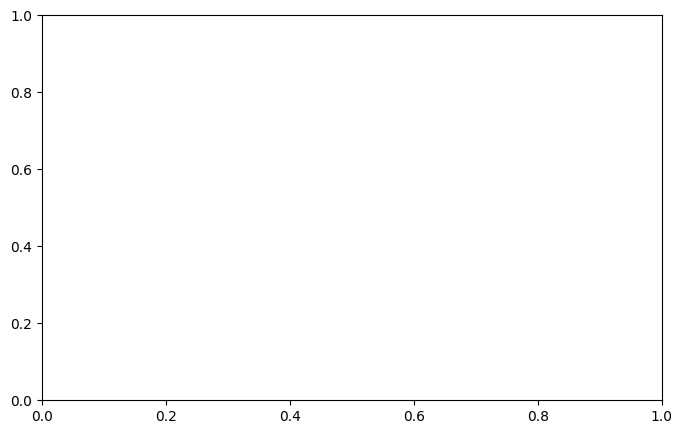

In [13]:
fig, ax = plt.subplots(figsize=(8, 5))

def update(frame):
    ax.clear()
    # ax.imshow(monthly_evi.isel(time=frame), add_colorbar=False, cmap='RdYlGn', vmin=-1, vmax=1)
    monthly_evi.isel(time=frame).plot.imshow(
        ax=ax, add_colorbar=False, cmap='RdYlGn', vmin=-1, vmax=1
    )

    ax.set_title(None)
    ax.set_aspect('equal')
    ax.axis('off')
    x_lim, ylim = ax.get_xlim(), ax.get_ylim()
    okt_gdf.boundary.plot(ax=ax, color='black', linewidth=1)
    
    ax.set_xlim(x_lim)
    ax.set_ylim(ylim)
    
    fig.suptitle(f"Oktibbeha County, MS Sentinel-2 Mean EVI\n" + \
        f"{monthly_evi['time'][frame].dt.strftime('%Y-%m').values}")
    
init_plot = monthly_evi.isel(time=0).plot.imshow(
    ax=ax, add_colorbar=True, cbar_kwargs={'label': 'EVI'},cmap='RdYlGn', vmin=-1, vmax=1
)

ani = FuncAnimation(fig, update, frames=len(monthly_evi['time']), repeat=False)

# show in notebook
HTML(ani.to_jshtml(fps=1, default_mode='once')) 

# plt.close()